# Exercise: Weather API

## Aim: Use a Weather API to create and graph NETCDF4 files

### Issues covered:

- Request and get data from a web API endpoint
- Read and retrieve information from a JSON response
- Write and read NETCDF4 files
- Create graphs from NETCDF4 files

## 1. Let's get data from a web API on the internet.

Use this url endpoint `https://api.weather.gov/` as the base.

First, specific to this API, we want to get a station ID and grid co-ordinates. To do so
we will use the `points/{latitude,longitude}` endpoint to get that information.

*Choose the latitude and longitude of your favourite US location (this API is US only and in
latitude North, longitude East)*

To get weather data of a specific location, we use the `gridpoints/{station ID}/{grid co-ordinates}`
endpoint to retrieve so.

In [1]:
import requests

With the request library, combine the `base url` and `points` and do a get request to a variable named `response`, can you print the status code?
If it is a 200, it passed!

In [2]:
url = 'https://api.weather.gov/'
latitude, longitude = '38.9072', '-77.0369'
response = requests.get(f'{url}points/{latitude},{longitude}')
response.status_code

200

Now with your response, retrieve the gridID, gridX and gridY values into their own respective variables.

In [3]:
# hint: turn your response into a JSON. A JSON is a dictionary,
# you can view the JSON on your browser by pasting the URL from the get request.

response = response.json()

gridID = response['properties']['gridId']
gridX = response['properties']['gridX']
gridY = response['properties']['gridY']

With your gridID, gridX, and gridY, use the `gridpoints` endpoint and do a get request, printing the status code.
If everything is working, you should get another 200 status code.

In [4]:
response = requests.get(f'{url}gridpoints/{gridID}/{gridX},{gridY}')
response.status_code

200

Can you get the JSON from the response and retrieve the forecast values for temperature?

In [5]:
data = response.json()
forecast = data['properties']['temperature']['values']

Retrieve the coordinates in a `x` and `y` variable from the JSON as well.

In [6]:
coords = data['geometry']['coordinates'][0][0]
x = coords[1]
y = coords[0]

## 2. Let's format that data and export as NETCDF4

### Format data

First, format your forecast data to get the datetime and air temperature as separate
lists.

In [7]:
from datetime import datetime as dt

Loop through your forecast values and get the temperatures `value` and dates `validTime` into a list.

In [8]:
# Use the datetime module to convert the times from the data to a datetime object.
# Hint: look at the validTime string and see how you can turn the string to datetime
#  using strptime.

timeseries = []
temps = []

for item in forecast:
    date = item['validTime']
    date = dt.strptime(date.split('/')[0], '%Y-%m-%dT%H:%M:%S%z')
    timeseries.append(date)
    temp = item['value']
    temps.append(temp)

Format the time list you just made and convert to relative time in seconds from the start
the timeseries. The NETCDF using the CF conventions stores time as an offset from a
base time rather than an absolute time.

In [9]:
base_time = timeseries[0]
time_values = []

for t in timeseries:
    value = t - base_time
    ts = value.total_seconds()
    time_values.append(ts)

time_units = "seconds since " + base_time.strftime('%Y-%m-%d %H:%M:%S')

Format the temps list you just made to Kelvins. As per CF conventions, the canonical units
for Air Temperature is degrees K.

In [10]:
temp_values = []

for t in temps:
    t = t + 273.15
    temp_values.append(t)

### Create NetCDF File

Create the output file (NetCDF dataset):
- Output file to the group workspace.
- Name your file as <Grid ID>_<name>_temps.nc

In [11]:
from netCDF4 import Dataset
import numpy as np

In [12]:
outfile = f'/Users/kazi.mahir/Documents/{gridID}_myName_temps.nc'
dataset = Dataset(outfile, "w", format="NETCDF4_CLASSIC")

Create the time dimension - with unlimited length

In [13]:
time_dim = dataset.createDimension('time', None)

Create the time variable with the following attributes:
- time variables as a numpy float
- units as time_units defined earlier
- standard_name as time
- calendar as standard

In [14]:
time_var = dataset.createVariable('time', np.float64, ('time',))
time_var[:] = time_values
time_var.units = time_units
time_var.standard_name = 'time'
time_var.calendar = 'standard'

Create the temp variable with the following attributes:
- temp variables as a numpy float
- var_id as temp
- long_name as air temperature (K)
- units as K
- standard_name as air_temperature
- coordinates as the x and y values from the coords variable defined before

In [15]:
temp_var = dataset.createVariable('temp', np.float32, ('time',))
temp_var[:] = temp_values
temp_var.var_id = 'temp'
temp_var.long_name = "Air Temperature (K)"
temp_var.units = 'K'
temp_var.standard_name = 'air_temperature'
temp_var.coordinates = (coords[1], coords[0])

Set the global attributes as follows:
- who: your name
- where: location of your forecast (grid ID or name)
- when: current datetime as day-month-year hour:minute
- why:
- how: forecast data gathered from weather API
- what: air temperature data in K of 7 day forecast

In [16]:
dataset.who = 'Mahir Rahman'
dataset.where = 'Washington DC'
dataset.when = dt.now().strftime('%d-%m-%Y %H:%M')
dataset.why = "why"
dataset.how = "forecast data gethered from weather API"
dataset.what = "air temperature data in K of 7 day forecast"

Save your NetCDF file by closing the dataset.

In [17]:
dataset.close()

## 3. Import NetCDF4 from Group Workspace

To find all the `.nc` files in a group workspace, we will use the glob module in Python.
Glob let's us find all files matching a pattern, in our case:

`<groupworkspace>/*.nc`

In [18]:
from glob import glob

Can you use glob to make a list of filepaths of all NetCDF files in the
group workspace?

In [19]:
filepaths = glob("/Users/kazi.mahir/Documents/*.nc")

## 4. Graph data from NetCDF
Now that we have a list of netCDF filepaths, we can open them and extract their data.

To start, let us make the plots using matplotlib.

In [20]:
from netCDF4 import num2date
import matplotlib.pyplot as plt
import  matplotlib.dates as mdates
%matplotlib inline

Create a subplots figure with figure and axis

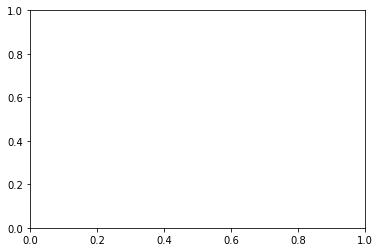

In [21]:
fig, ax = plt.subplots();

Can you set the x-axis locator (ticks) using dates class from matplotlib?
- set the major locator to days.
- set the minor locator to every 6 hours.
- set the x-axis formatter to Day-Month for each day.

In [22]:
fmt_day = mdates.DayLocator()
fmt_six_hours = mdates.HourLocator(interval=6)

ax.xaxis.set_major_locator(fmt_day)
ax.xaxis.set_minor_locator(fmt_six_hours)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

Label the axis on the plot:
- label the x-axis as date
- label the y-axis as air temperature / K
- set a title to your plot

In [23]:
ax.set_xlabel("Date")
ax.set_ylabel("Air Temperature / K")
ax.set_title("Air temperature Forecast")

Text(0.5, 1.0, 'Air temperature Forecast')

Open the netCDF file and extract the `temp` and `time` variables from the file and use
matplotlib `plot_date` function to plot the graph, looping through each file.
- set the label of plot to the coordinate attribute of the temp variable.

Plot a line graph using matplotlib.

In [24]:

# Hint: to use plot_date, you will need to convert the times in the time variable
# of the dataset to a datetime object using num2date.

for f in filepaths:
    net = Dataset(f, mode='r')
    temps = net.variables['temp'][:]
    times = net.variables['time'][:]
    times = num2date(times[:],
                     units=net.variables['time'].units,
                     calendar=net.variables['time'].calendar)
    ax.plot_date(times, temps, '-', label=net.variables['temp'].coordinates)

Finally, show the plot with a legend, you might want to enable tight layout,
and save the plot to your personal space.

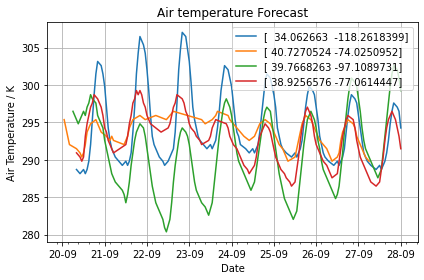

In [25]:
ax.grid(True)
fig.tight_layout()
ax.legend()
fig